### credit:
**Resnet code** is adopted and generalized from https://blog.csdn.net/weixin_43940163/article/details/103760294<br>
**Setup_seed code** is adopted from https://zhuanlan.zhihu.com/p/76472385

The employed tricks:
- CosineAnnealingWarmRestarts
- Float16 (abandoned, since it does not accelerate training)
- linear scaling lr with batchsize=128
- model tweak: ResNet-D
- label smoothing

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy
import json

plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def load_data(TRAIN_BS):
    data_dir = '/kaggle/input/caltech101/Caltech101/Caltech101'
    data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop((224,224), scale=(0.6,1)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'eval': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'eval', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['eval', 'test']}
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=TRAIN_BS, shuffle=True, num_workers=4)
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    return dataloaders, dataset_sizes, class_names, num_classes, device

In [5]:
class LabelSmoothing(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [6]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.act1  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.act2  = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(out_planes, out_planes*4, kernel_size=1, stride=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_planes*4)
        self.act3  = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.act3(out)
        
        return out
        
        
class Resnet50D(nn.Module):
    def __init__(self, num_classes=101):
        self.in_planes = 64
        
        super(Resnet50D,self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.layer1 = self.make_layers(3, stride=1, planes=64)
        self.layer2 = self.make_layers(4, stride=2, planes=128)
        self.layer3 = self.make_layers(6, stride=2, planes=256)
        self.layer4 = self.make_layers(3, stride=2, planes=512)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        nn.init.zeros_(self.layer4[2].bn3.weight)
  
    def make_layers(self, repeat_times, stride, planes):
        if stride==2:
            downsample = nn.Sequential(
                    nn.AvgPool2d(2, stride=2),
                    nn.Conv2d(self.in_planes, planes*4, kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes*4)
            )
        else:
            downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes*4,kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes*4)
            )
        layers=[]
        layers.append(Block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes*4
        for i in range(repeat_times-1):
            layers.append(Block(self.in_planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # conv2_x
        x = self.maxPool(x)
        x = self.layer1(x)
        
        # conv3_x
        x = self.layer2(x)
        
        # conv4_x
        x = self.layer3(x)
        
        # conv5_x
        x = self.layer4(x)

        # average pool and fc
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x =self.fc(x)
        
        return x

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, sch=False):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)

                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        if sch:
                            scheduler.step(epoch + step / iters)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
#             if sch and (phase == 'train'):
#                 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics, lrs

In [8]:
def visualize_accuracy(num_epochs, statistics, fig_name):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.savefig(fig_name)

In [9]:
def test_model(model, details=False):  
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for count,data in enumerate(dataloaders['test']):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('test accuracy: %d %%' % (100 * correct / total))
    if details:
        acc_dic = {}
        for i in range(num_classes):
            acc = 100 * class_correct[i] / class_total[i]
            acc_dic[class_names[i]] = acc
            print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

cuda:0
Epoch 0/119
----------
train Loss: 5.0493 Acc: 0.0995
eval Loss: 111.5052 Acc: 0.1122

Epoch 1/119
----------
train Loss: 4.3030 Acc: 0.1256
eval Loss: 4.1914 Acc: 0.1622

Epoch 2/119
----------
train Loss: 4.1486 Acc: 0.1475
eval Loss: 4.9700 Acc: 0.2085

Epoch 3/119
----------
train Loss: 3.9702 Acc: 0.1991
eval Loss: 3.8930 Acc: 0.2268

Epoch 4/119
----------
train Loss: 3.7350 Acc: 0.2316
eval Loss: 4.4738 Acc: 0.2061

Epoch 5/119
----------
train Loss: 3.6192 Acc: 0.2533
eval Loss: 3.8997 Acc: 0.2317

Epoch 6/119
----------
train Loss: 3.4767 Acc: 0.2895
eval Loss: 3.6795 Acc: 0.2659

Epoch 7/119
----------
train Loss: 3.3379 Acc: 0.3145
eval Loss: 3.5916 Acc: 0.2841

Epoch 8/119
----------
train Loss: 3.1809 Acc: 0.3515
eval Loss: 3.8826 Acc: 0.3085

Epoch 9/119
----------
train Loss: 3.0761 Acc: 0.3749
eval Loss: 3.4354 Acc: 0.3512

Epoch 10/119
----------
train Loss: 2.9302 Acc: 0.4135
eval Loss: 3.0362 Acc: 0.4049

Epoch 11/119
----------
train Loss: 2.7721 Acc: 0.4484


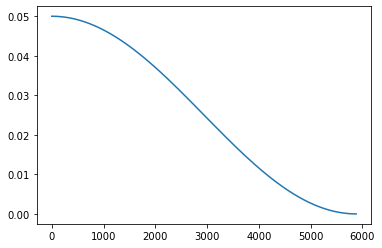

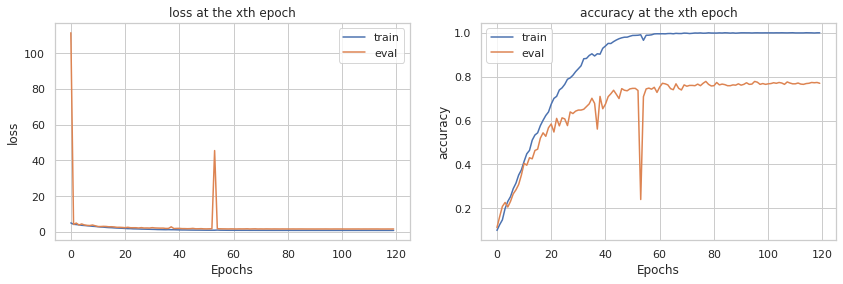

In [10]:
setup_seed(20)
dataloaders, dataset_sizes, class_names, num_classes, device = load_data(128)

RN_f16 = Resnet50D()
RN_f16 = RN_f16.to(device)
num_epochs = 120
criterion_f16 = LabelSmoothing(0.1)
optimizer_f16 = optim.SGD(RN_f16.parameters(), lr=0.05, momentum=0.9)
cosine_lr_scheduler_f16 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_f16, T_0=120, eta_min=0, last_epoch=-1)

RN_f16, statistics_f16, lrs = train_model(RN_f16, criterion_f16, optimizer_f16, cosine_lr_scheduler_f16, num_epochs=num_epochs, sch=True)

json.dump(statistics_f16, open('RN_f16.json', 'w'))
lr = np.array(lrs)[:,1]
plt.plot(np.arange(len(lr)), lr);
visualize_accuracy(num_epochs, statistics_f16, 'RN_f16.png')

torch.save(RN_f16.state_dict(), '/kaggle/working/RN_f16.pth')
test_model(RN_f16)